## Image classification with Convolutional Neural Networks

Welcome to the first week of the second deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Introduction to our first task: 'Dogs vs Cats'

We're going to try to create a model to enter the Dogs vs Cats competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

Here is the dataset http://files.fast.ai/data/dogscats.zip. You can donwload it directly on your server by running the following line in your terminal. "wget http://files.fast.ai/data/dogscats.zip"

In [2]:
# This file contains all the main external libs we'll use
from imports import *

In [3]:
PATH = "data/dogscats/"

### First look at cat pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [4]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [5]:
!ls {PATH}valid

cats  dogs


In [6]:
files = !ls {PATH}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

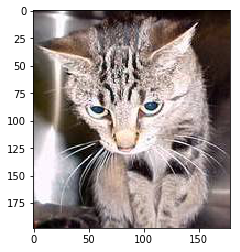

In [7]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [8]:
img.shape

(198, 179, 3)

In [9]:
img[:4,:4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

### Our first model

Here we import the libraries we need. We'll learn about what each does during the course.

In [10]:
from fast_gen import *
from conv_learner import *
from pt_models import *
from dataset_pt import *
from sgdr_pt import *

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained onImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds of compute time:

In [11]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(resnet34, 299))
learn = ConvLearner.pretrained(resnet34, data, use_fc=True)
learn.fit(0.01, 2)

A Jupyter Widget

A Jupyter Widget

[ 0.0372  0.0255  0.9902]


A Jupyter Widget

[ 0.0384  0.0246  0.9907]



How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds!

#### Understanding the code for our first model

Let's look at this code line by line.

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing (we are going to use size 299x299 images), image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

In [12]:
tfms = tfms_from_model(resnet34, 299)

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results. `ImageClassifierData.from_paths` reads data from a provided path and creates a dataset ready for training.

In [13]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` builds *learner* that contains a pretrained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes but we need a model with two classes (cats and dogs). These weights of that layer are iniliatized randomly. The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs. The top layers are fronzen while the new layer gets trained.

<img src="imgs/pretrained.png" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [15]:
learn = ConvLearner.pretrained(resnet34, data)

In the figure above the layers represented by cubes are called the *convolutional layers* while the fatter-looking layers are called *fully connected*. We could *cut* the convolutional layers from the fully connected layers. Let's call the model with convolutional layers the *top_model* and the fully connected model the *fc_model*. If we wanted to train just the weights in the fc_model a good strategy is to do the following:

1. For each image in your training data store the output of the top_model
2. Use the output from top_model as input to the fc_model to train the fully connected layers
3. Put together the top_model with the fc_model to get a full model. This strategy is equivalent to training the whole model but much faster.

The next line of code it telling our library to do exactly that.

In [16]:
learn.use_fc=True

We can now *fit* the model&mdash;that is, use *gradient descent* (which we will be studying later) to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass two parameters: the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [17]:
learn.fit(1e-2, 2)

A Jupyter Widget

A Jupyter Widget

[ 0.0433  0.0238  0.9893]


A Jupyter Widget

[ 0.0311  0.0224  0.9932]



#### Choosing a learning rate

The **learning rate** determines how quickly or how slowly you want to update the weight parameters in gradient descent. Usually, you want to start with a large learning rate, and gradually decrease the learning rate as the training progresses. 

`learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like. Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

A Jupyter Widget

A Jupyter Widget

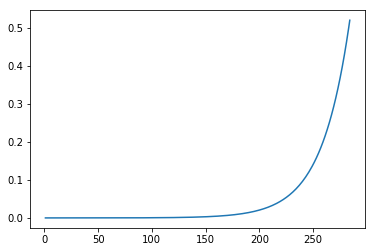

In [18]:
lrf=learn.lr_find()
learn.sched.plot_lr()

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

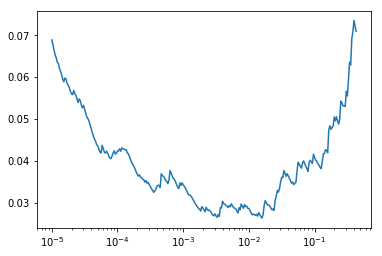

In [19]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizaing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [20]:
from plots import *

In [21]:
tfms = tfms_from_model(resnet34, 299, aug_tfms=transforms_side_on, max_zoom=1.1)

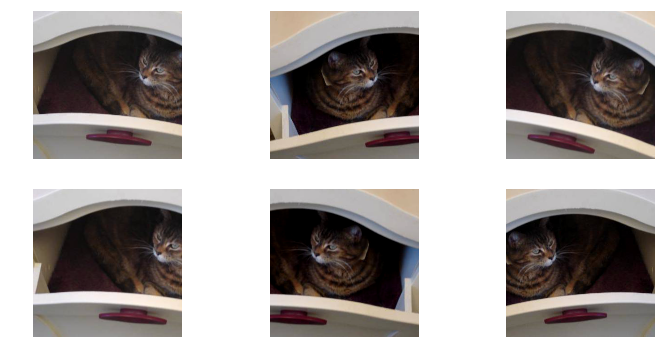

In [22]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [24]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(resnet34, data, use_fc=True)

In [25]:
learn.fit(1e-2, 1)

A Jupyter Widget

A Jupyter Widget

[ 0.0376  0.0239  0.9907]



In [26]:
learn.use_fc = False

In [27]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

A Jupyter Widget

[ 0.0414  0.0242  0.9917]


A Jupyter Widget

[ 0.0415  0.0248  0.9902]


A Jupyter Widget

[ 0.0365  0.0234  0.9907]


A Jupyter Widget

[ 0.0425  0.0269  0.9897]


A Jupyter Widget

[ 0.0271  0.0259  0.9902]


A Jupyter Widget

[ 0.029   0.0258  0.9888]


A Jupyter Widget

[ 0.0292  0.0263  0.9902]



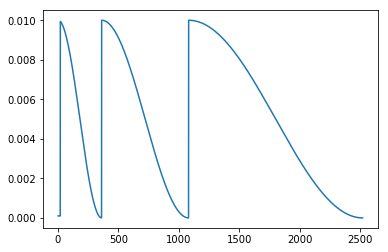

In [28]:
learn.sched.plot_lr()

In [29]:
accuracy(*learn.TTA())

0.99150000000000005

In [30]:
learn.save('299_fc')

In [35]:
learn.unfreeze()

In [79]:
learn.load('299_fc')

In [80]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

A Jupyter Widget

[ 0.0432  0.0232  0.9888]


A Jupyter Widget

[ 0.034   0.0211  0.9912]


A Jupyter Widget

In [ ]:
accuracy(*learn.TTA())

In [ ]:
learn.sched.plot_loss()

In [37]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

A Jupyter Widget

[ 0.047   0.0234  0.9897]


A Jupyter Widget

[ 0.0277  0.0179  0.9912]


A Jupyter Widget

[ 0.0301  0.016   0.9937]


A Jupyter Widget

[ 0.0371  0.0156  0.9932]


A Jupyter Widget

[ 0.0249  0.0163  0.9946]


A Jupyter Widget

[ 0.0235  0.015   0.9951]


A Jupyter Widget

[ 0.0189  0.017   0.9932]


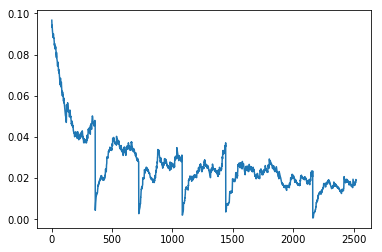

In [39]:
learn.sched.plot_loss()

In [38]:
accuracy(*learn.TTA())

0.99399999999999999

### Class Saliency Visualisation

This method allows an object classifier to be used for object localization, or to better understand misclassifications.

In [2]:
from IPython.display import display, Math, Latex

Our model visualization is a version of this.
[script](https://github.com/leelabcnbc/cnnvis-pytorch/blob/master/test.ipynb). The details of this approach are descriped in this [paper](https://arxiv.org/pdf/1312.6034.pdf).

Given an image $I_0$, a class $c$, and a classification ConvNet with the class score function $Sc(I)$, we would like to rank the pixels of $I_0$ based on their influence on the score $Sc(I_0)$.

In [3]:
bs=1
f_model = resnet34
path = "/data/yinterian/dogscats/"
sz=299
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(path, bs, tfms, test_name='test1')
learn = ConvLearner.pretrained(f_model, data)
learn.load('299_no')

In [4]:
# to get the first element of the validation data
x, y = data.val_dl.dataset[5]
model = learn.model
denorm = tfms[0].denorm
x2 = np.rollaxis(x, 0, 3)
x_org = denorm(x2)

In [5]:
print(x.shape, x2.shape, x_org.shape)

(3, 299, 299) (299, 299, 3) (299, 299, 3)


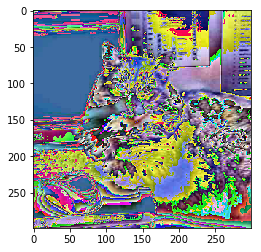

In [6]:
plt.imshow(x2)

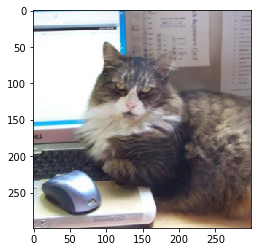

In [7]:
plt.imshow(x_org)

In [8]:
_ = model.eval()

In [9]:
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor

In [10]:
x.shape

(3, 299, 299)

In [11]:
xx = T(x).unsqueeze(0)
xx.size()
xx = xx.contiguous()

In [12]:
input_img = Parameter(xx.cuda(async=True), requires_grad=True)

In [13]:
if input_img.grad is not None:
    input_img.grad.data.zero_()

In [14]:
model.zero_grad()

In [15]:
raw_score = model(input_img)

In [16]:
raw_score_numpy = raw_score.data.cpu().numpy()
print(np.around(np.exp(raw_score_numpy), decimals=4))

[[ 1.  0.]]


In [17]:
def show_images(img_original, saliency, title):
    # convert from c01 to 01c
    print(saliency.min(), saliency.max(), saliency.mean(), saliency.std())
    saliency = saliency[::-1]  # to BGR
    saliency = saliency.transpose(1, 2, 0)
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(10, 10), facecolor='w')
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(np.asarray(img_original))
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency).max(axis=-1), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.suptitle(title)
    plt.show()

In [18]:
loss = raw_score.sum()

In [19]:
loss.backward(retain_variables=True)

/home/yinterian/anaconda/lib/python3.6/site-packages/torch/autograd/__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


-0.459269 0.376274 -4.71647e-06 0.0246497


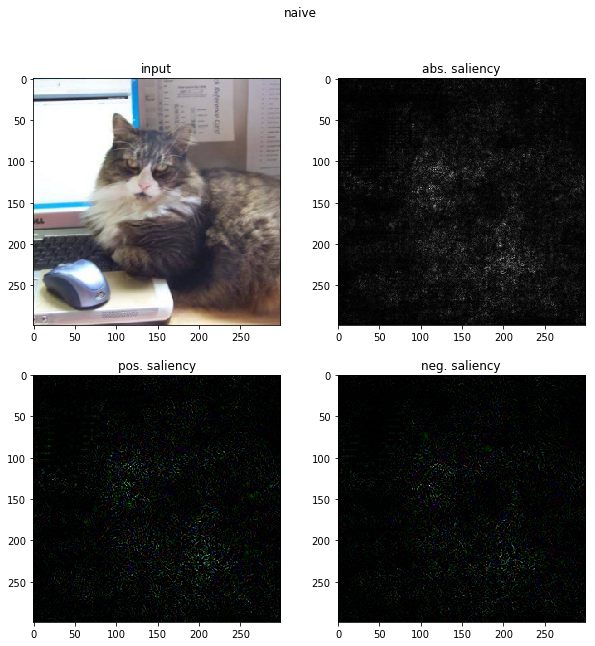

In [20]:
show_images(x_org, input_img.grad.data.cpu().numpy()[0], 'naive')


### Visualizing kernels

In [86]:
# to look at the model
#print(model)

In [100]:
def plot_first_layer_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        kernel = tensor[i]
        kernel = np.rollaxis(kernel, 0, 3)
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(kernel)
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [22]:
mm = model.double()

In [40]:
filters = mm.modules
layer1 = [i for i in mm.children()][0]
tensor = layer1.weight.data.cpu().numpy()

In [54]:
tensor.shape

(64, 3, 7, 7)

In [60]:
layer1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [63]:
# 18 children
[i for i in mm.children()][4][0]

BasicBlock (
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
)

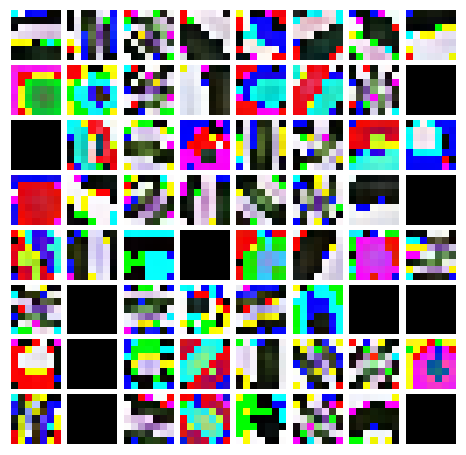

In [68]:
# here are the 64 7x7x3 top kernels
plot_first_layer_kernels(tensor, num_cols=8)

In [80]:
layer2 = mm[4][0].conv1
tensor2 = layer2.weight.data.cpu().numpy()

In [93]:
tensor2.shape 

(64, 64, 3, 3)

In [101]:
def plot_kernels_v2(tensor):
    num_kernels = tensor.shape[0]*tensor.shape[1]
    num_cols = tensor.shape[0]
    num_rows = tensor.shape[1]
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            kernel = tensor[i][j]
            ax1 = fig.add_subplot(num_rows,num_cols,i+1 + j*i)
            ax1.imshow(kernel, cmap='gray')
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

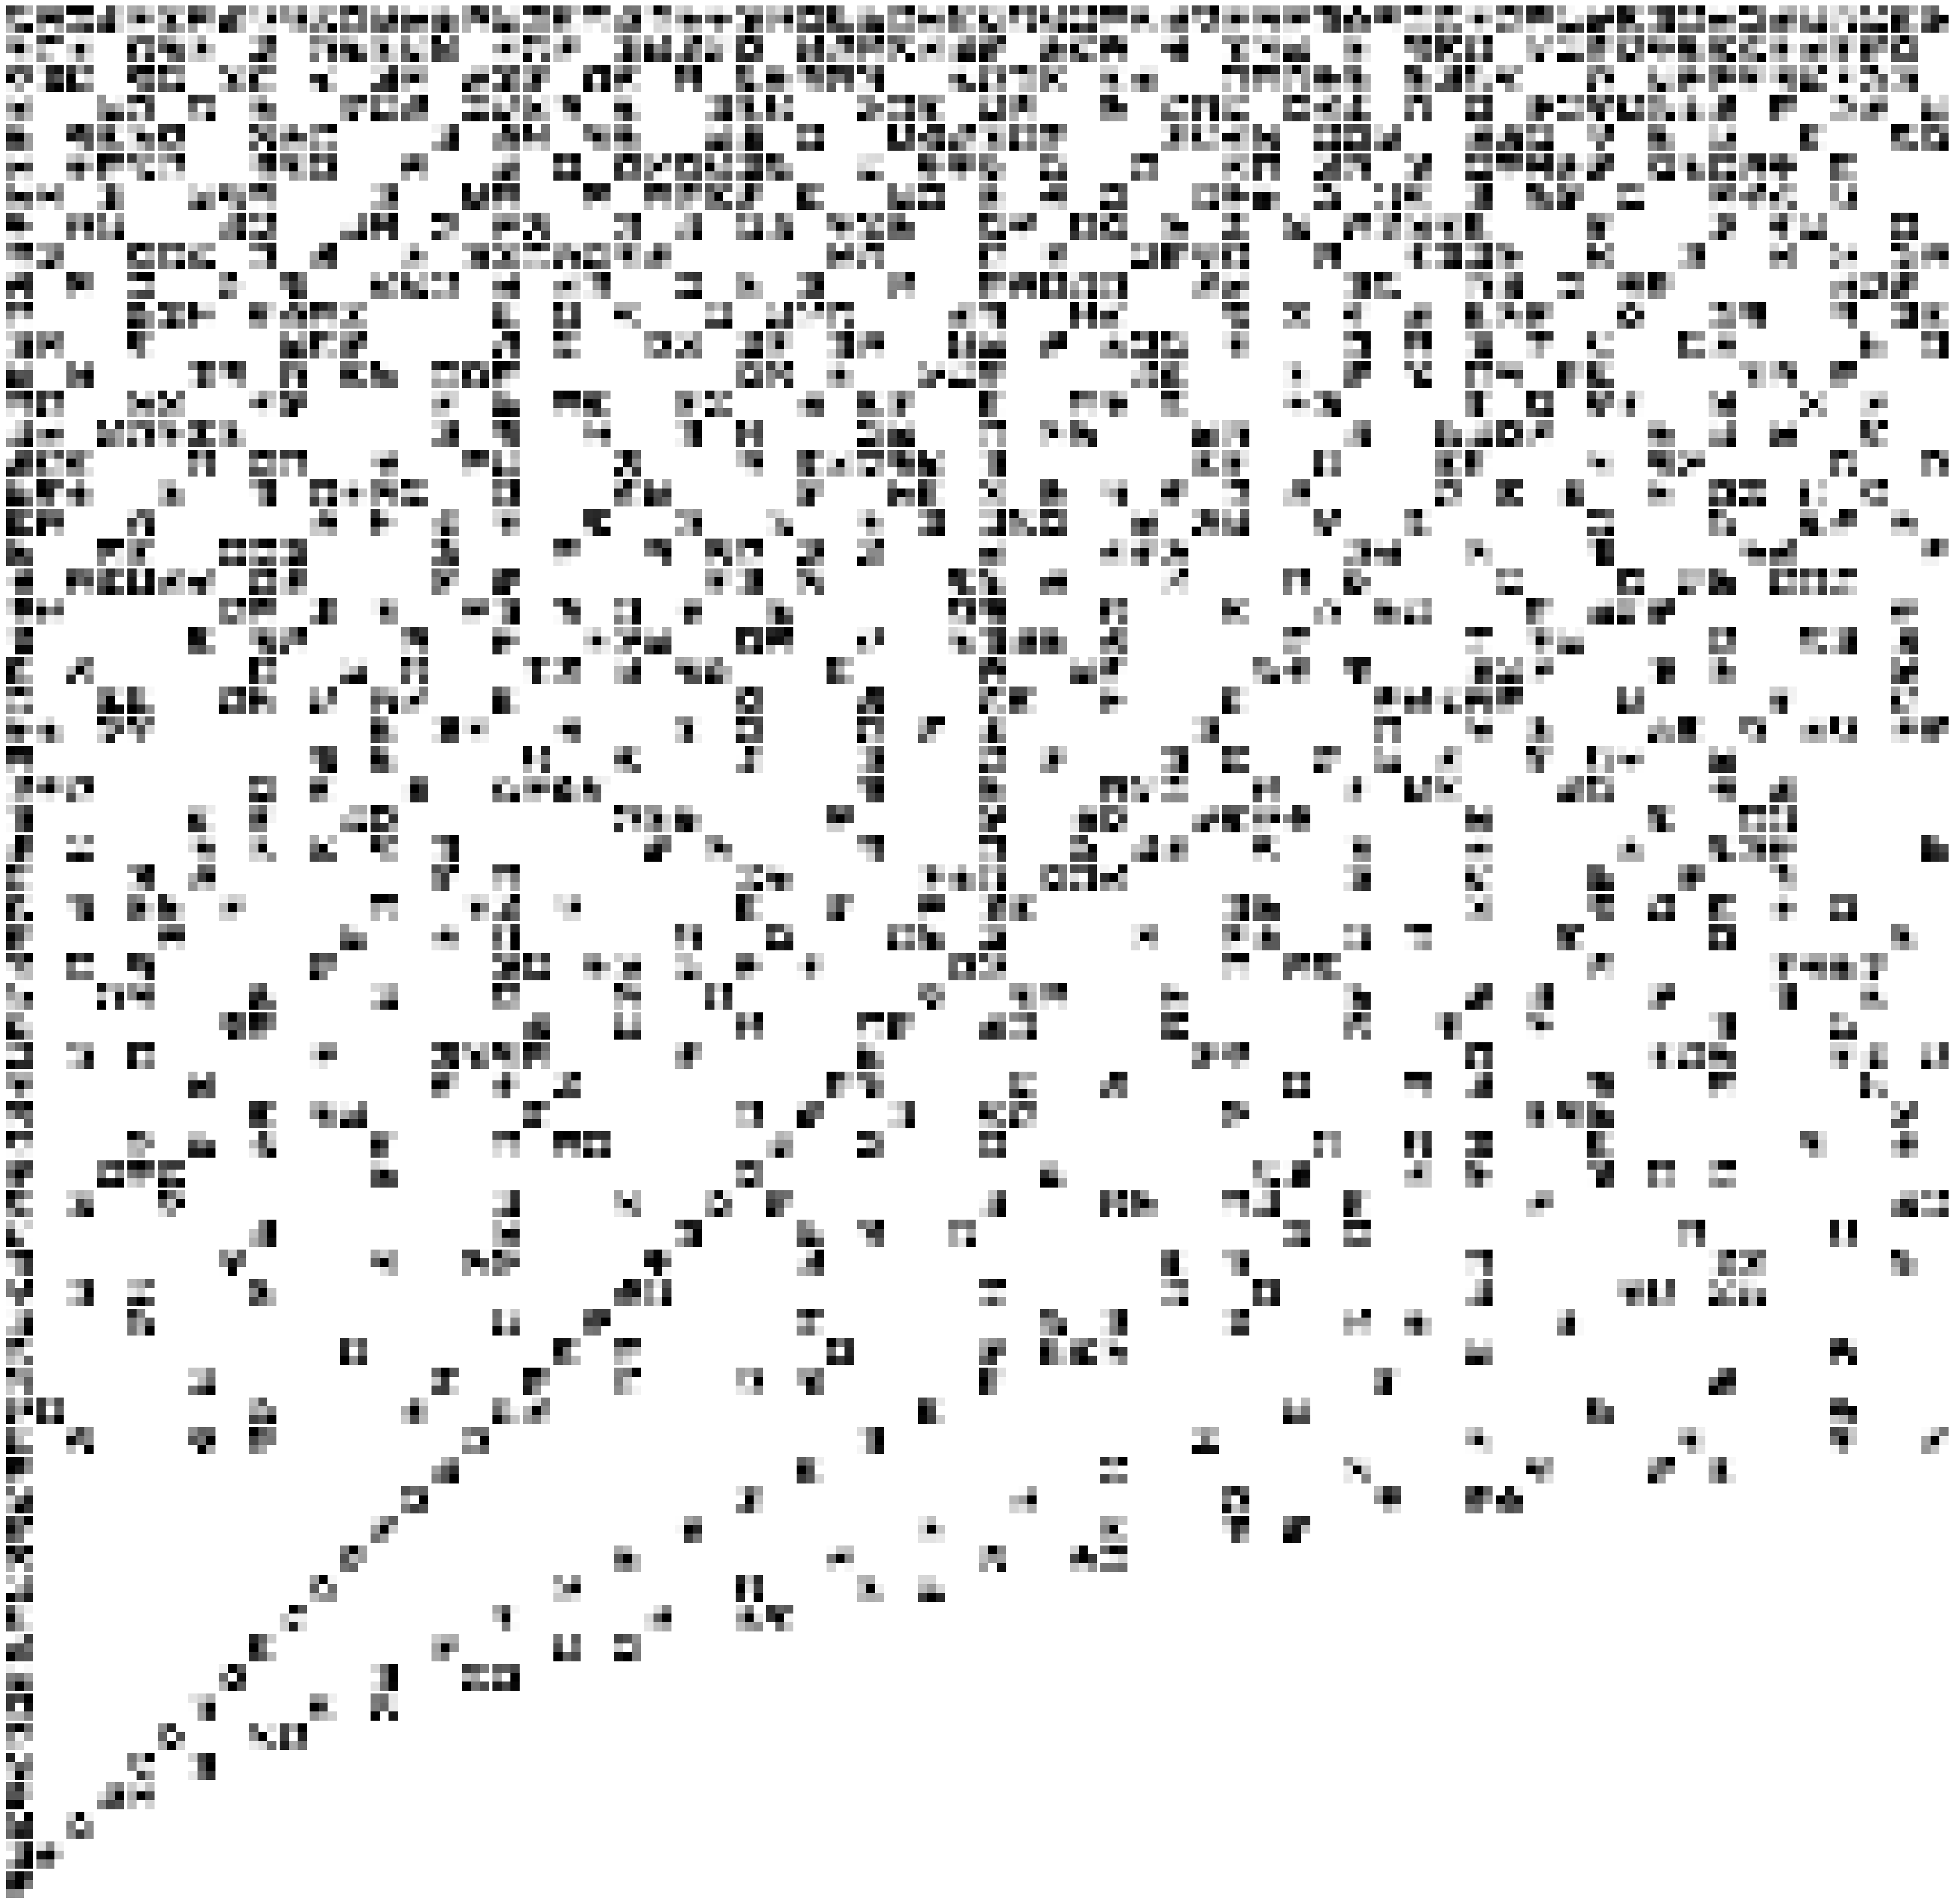

In [99]:
#This is not the right way of visualizing this
plot_kernels_v2(tensor2)

In [96]:
tensor2[0][0].shape

(3, 3)

## Planet

Terminology:
* <b>Stochastic Gradient descent (SGD)</b> is an optimization procedure that is used to find optimal parameters (weights) in machine learning models. More details [here](http://ruder.io/optimizing-gradient-descent/).
* Batch size (e.g. bs = 64) is the number of training examples in step of the SGD optimization. The higher the batch size, the more memory space you'll need.
* Resolution of the image (e.g. sz=64) is used for resizing the image before training. In deep learning images are often resized to a square of size szxsz. Many models come with a fixed input size. Resnet models can be trained with different sizes.
* A <b>pre-trained</b> model is a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, you use the model trained on other problem as a starting point. We used models trained with ImageNet (1.2 million images and 1000 classes.)
* Convolutional Neural Network is a type of Neural Network that builds state-of-the-art models for computer vision.

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. For a few lectures we are just going to be using models without getting too much into the details. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks).

The method <b>resize</b> creates a temporary file with resized images. This is for speeding up training.

In [8]:
data = data_full.resize(128, 'tmp') if sz<=90 else data_full

In [ ]:
tfm=Transforms(64, [Scale(64)], rand_crop=True)
data = ClassifierData.from_paths(data.path, 2, (tfm, tfm))
x,y=next(iter(ds.val_dl))
plt.imshow(np.rollaxis(x[0].numpy(),0,3));

In [ ]:
im=PIL.Image.open(data_full.path+'/'+data_full.val_dl.dataset.fnames[0])
plt.imshow(cv2.resize(np.array(im), (64,64), interpolation=cv2.INTER_NEAREST));

In [ ]:
im=PIL.Image.open(data_full.path+'/'+data_full.val_dl.dataset.fnames[0])
plt.imshow(cv2.resize(np.array(im), (64,64)));